In [1]:
import pandas as pd
from hallucinate import Experiment, EstimatorConfig
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
feature_names = train_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], 1).columns.values
experiment = Experiment(name='Titanic', cv=30, sc='accuracy', cv_shuffle=False, parallel=True)
features = experiment.make_features(name='Default Features',
                                    features=feature_names,
                                    train_data=train_df, 
                                    test_data=test_df,
                                    target='Survived')

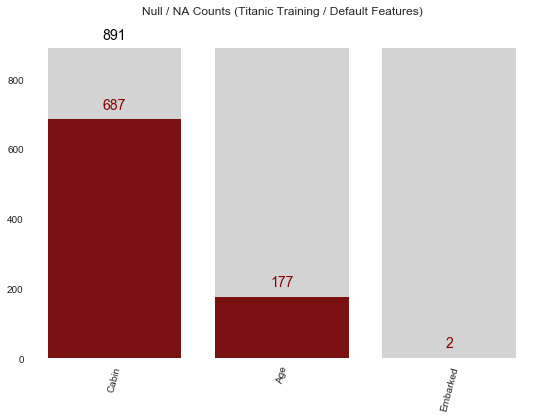

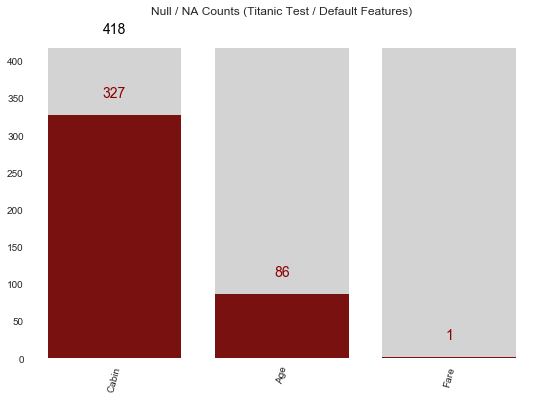

In [3]:
experiment.show_null_stats()

In [4]:
experiment.overview()


Experiment: 'Titanic'

Feature Source: 'Default Features'

 o Training samples: 891
 o Test samples: 418
 o Target: 
  - Survived: 2 -> 0.0 (549), 1.0 (342)

 o Categorical features: 3 -> Sex, Cabin, Embarked
  - Sex: 2 -> male (577), female (314)
  - Cabin (77.10% missing): 147 -> B96 B98 (4), G6 (4), C23 C25 C27 (4), F2 (3), C22 C26 (3) and 142 others
  - Embarked (0.22% missing): 3 -> S (644), C (168), Q (77)

 o Numerical features: 5 -> Pclass, Age, SibSp, Parch, Fare
  - Pclass: 3 -> 3.00 (491), 1.00 (216), 2.00 (184)
  - Age (19.87% missing): 88 -> 24.00 (30), 22.00 (27), 18.00 (26), 30.00 (25), 19.00 (25) and 83 others
  - SibSp: 7 -> 0.00 (608), 1.00 (209), 2.00 (28), 4.00 (18), 3.00 (16) and 2 others
  - Parch: 7 -> 0.00 (678), 1.00 (118), 2.00 (80), 5.00 (5), 3.00 (5) and 2 others
  - Fare: 248 -> 8.05 (43), 13.00 (42), 7.90 (38), 7.75 (34), 26.00 (31) and 243 others

 o Before pre-processing: 8 -> Pclass, Sex, Age, SibSp, Parch and 3 others
 o After pre-processing: 8 -> Pcl

In [5]:
def extract_cabin(df):
    return df['Cabin'].apply(lambda x: x[0])

# Categorical
features.transform(['Sex'], 'map', mapping={'male': 0, 'female': 1})
features.transform(['Cabin'], 'fillna', strategy='value', value='XXX')
features.transform(['Cabin'], 'method', method_handle=extract_cabin)
features.transform(['Embarked'], 'fillna', strategy='value', value='S') # most frequent value

# Numerical
features.transform(['Age'], 'fillna', strategy='median')
features.transform(['Fare'], 'fillna', strategy='mean')

# All
features.transform(['Pclass', 'Cabin', 'Embarked'], 'onehot')
features

 -- FEATURES: Pclass, Sex, Age, SibSp, Parch, Fare, Cabin, Embarked
  -- TRANSFORM: Sex -> mapping
  -- TRANSFORM: Cabin -> fillna
  -- TRANSFORM: Cabin -> method
  -- TRANSFORM: Embarked -> fillna
  -- TRANSFORM: Age -> fillna
  -- TRANSFORM: Fare -> fillna
  -- TRANSFORM: Pclass, Cabin, Embarked -> onehot

In [6]:
experiment.show_null_stats(preprocess=True)

No null values found in 'Titanic Training / Default Features'
No null values found in 'Titanic Test / Default Features'


In [7]:
experiment.add_estimator(EstimatorConfig(RandomForestClassifier(n_jobs=1), {'max_depth': [3, 6, 9]}, 'RF'))
experiment.add_estimator(EstimatorConfig(ExtraTreesClassifier(n_jobs=1), {'min_samples_split': [5, 10]}, 'XTR'))
experiment.add_estimator(EstimatorConfig(DecisionTreeClassifier(), {'min_samples_split': [5, 10]}, 'DTR'))
experiment.grid_search_all(verbose=True)

Experiment 'Titanic', running grid search...

o DTR: mean: 0.8061, std: 0.07 (Default Features: 20/20), best params: {'min_samples_split': 10}

o XTR: mean: 0.8189, std: 0.07 (Default Features: 20/20), best params: {'min_samples_split': 10}

o RF: mean: 0.8212, std: 0.08 (Default Features: 20/20), best params: {'max_depth': 9}



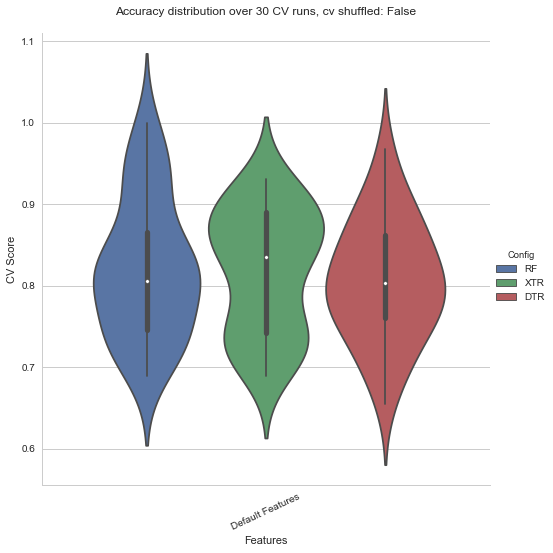

In [8]:
experiment.plot_cv_runs()

Experiment 'Titanic', running grid search...



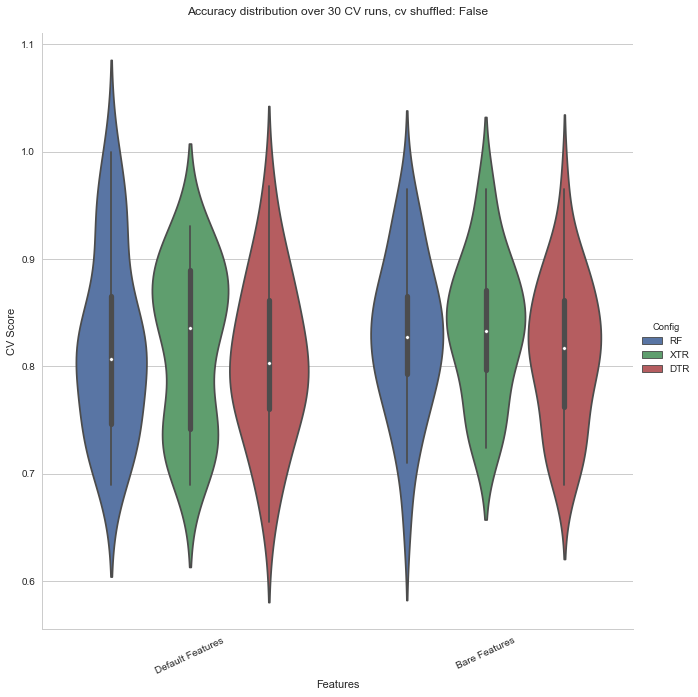

In [9]:
bare_features = experiment.make_features(name='Bare Features',
                                         features=['Pclass', 'Sex', 'Age', 'Fare'],
                                         train_data=train_df,
                                         test_data=test_df,
                                         target='Survived')
# Categorical
bare_features.transform(['Sex'], 'map', mapping={'male': 0, 'female': 1})
bare_features.transform(['Age'], 'fillna', strategy='median')
bare_features.transform(['Fare'], 'fillna', strategy='mean')
bare_features.transform(['Pclass'], 'onehot')
experiment.grid_search_all(verbose=False)
experiment.plot_cv_runs(figsize=9)

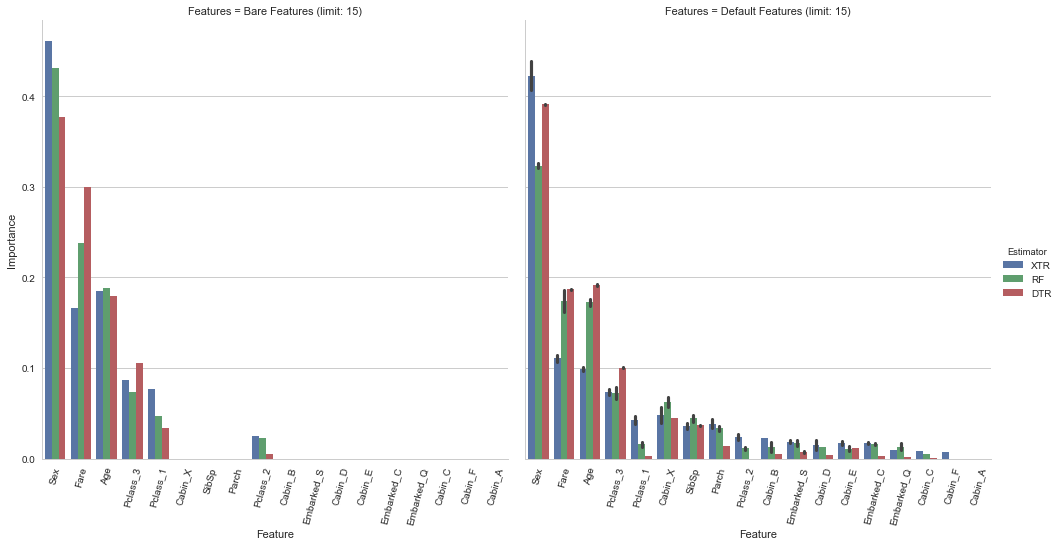

In [10]:
experiment.plot_feature_importance()

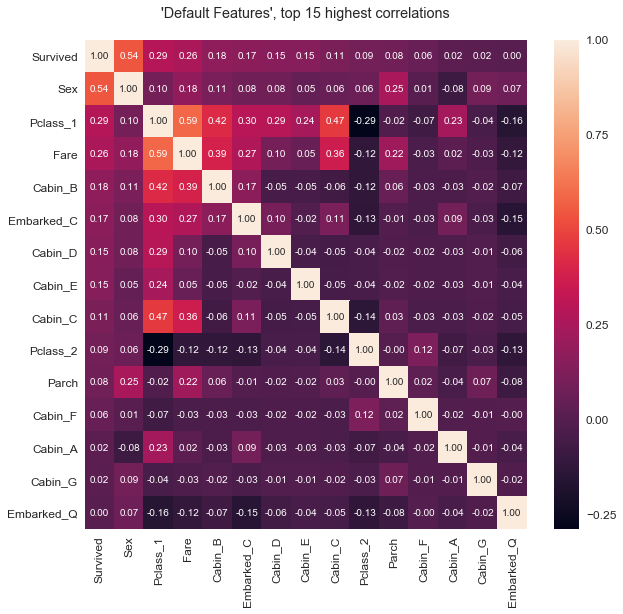

In [13]:
experiment.plot_correlations(figsize=9, features='Default Features')